In [8]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# !pip install tqdm
# !pip install scikit-learn
# !pip install matplotlib

### LINK: https://github.com/SainingZhang/DDAMFN

### Mixed Feature Network

In [9]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
import torch
import torch.nn as nn
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output
  

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

NON_LINEARITY = {
    'ReLU': nn.ReLU(inplace=True),
    'Swish': Swish(),
}        


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)

class swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class CoordAtt(nn.Module):
    def __init__(self, inp, oup, groups=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        mip = max(8, inp // groups)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.conv2 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.relu = h_swish()

    def forward(self, x):
        identity = x
        n,c,h,w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.relu(y) 
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        x_h = self.conv2(x_h).sigmoid()
        x_w = self.conv3(x_w).sigmoid()
        x_h = x_h.expand(-1, -1, h, w)
        x_w = x_w.expand(-1, -1, h, w)

        y = identity * x_w * x_h

        return y

        
class MDConv(Module):
    def __init__(self, channels, kernel_size, split_out_channels, stride):
        super(MDConv, self).__init__()
        self.num_groups = len(kernel_size)
        self.split_channels = split_out_channels
        self.mixed_depthwise_conv = nn.ModuleList()
        for i in range(self.num_groups):
            self.mixed_depthwise_conv.append(Conv2d(
                self.split_channels[i],
                self.split_channels[i],
                kernel_size[i],
                stride=stride,
                padding=kernel_size[i]//2,
                groups=self.split_channels[i],
                bias=False
            ))
        self.bn = BatchNorm2d(channels)
        self.prelu = PReLU(channels)            
       
    def forward(self, x):
        if self.num_groups == 1:
            return self.mixed_depthwise_conv[0](x)

        x_split = torch.split(x, self.split_channels, dim=1)
        x = [conv(t) for conv, t in zip(self.mixed_depthwise_conv, x_split)]
        x = torch.cat(x, dim=1)

        return x        
      
        
class Mix_Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1, kernel_size=[3,5,7], split_out_channels=[64,32,32]):
        super(Mix_Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = MDConv(channels=groups, kernel_size=kernel_size, split_out_channels=split_out_channels, stride=stride)
        self.CA = CoordAtt(groups, groups)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.CA(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output
          
class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)
        
class Mix_Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5], split_out_channels=[64,64]):
        super(Mix_Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Mix_Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups, kernel_size=kernel_size, split_out_channels=split_out_channels ))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)
        

class MixedFeatureNet(Module):
    def __init__(self, embedding_size=256, out_h=7, out_w=7):
        super(MixedFeatureNet, self).__init__()
        #112x112
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        #56x56
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Mix_Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, kernel_size=[3,5,7], split_out_channels=[64,32,32] )
        
        #28x28
        self.conv_3 = Mix_Residual(64, num_block=9, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5], split_out_channels=[96,32])
        self.conv_34 = Mix_Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256, kernel_size=[3,5,7],split_out_channels=[128,64,64] )
        
        #14x14
        self.conv_4 = Mix_Residual(128, num_block=16, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5], split_out_channels=[192,64])
        self.conv_45 = Mix_Depth_Wise(128, 256, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512*2, kernel_size=[3,5,7,9],split_out_channels=[128*2,128*2,128*2,128*2] )
        #7x7
        self.conv_5 = Mix_Residual(256, num_block=6, groups=512, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5,7], split_out_channels=[86*2,85*2,85*2])                
        self.conv_6_sep = Conv_block(256, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(out_h, out_w), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2_dw(out)
        out = self.conv_23(out)
        out = self.conv_3(out)
        out = self.conv_34(out)
        out = self.conv_4(out)
        out = self.conv_45(out)
        out = self.conv_5(out)
        out = self.conv_6_sep(out)
        out = self.conv_6_dw(out)
        out = self.conv_6_flatten(out)
        out = self.linear(out)
        out = self.bn(out)

        return l2_norm(out)

### DDAMFN++ Network

In [10]:
from torch import nn
import torch
# from networks import MixedFeatureNet
from torch.nn import Module
import os
class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = nn.Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
        
class DDAMNet(nn.Module):
    def __init__(self, num_class=7,num_head=2, pretrained=True):
        super(DDAMNet, self).__init__()

        # net = MixedFeatureNet.MixedFeatureNet()
        net = MixedFeatureNet()
                
        if pretrained:
            net = torch.load(os.path.join('./pretrained/', "MFN_msceleb.pth"), weights_only=False)       
      
        self.features = nn.Sequential(*list(net.children())[:-4])
        self.num_head = num_head
        for i in range(int(num_head)):
            setattr(self,"cat_head%d" %(i), CoordAttHead())                  
      
        self.Linear = Linear_block(512, 512, groups=512, kernel=(7, 7), stride=(1, 1), padding=(0, 0))
        self.flatten = Flatten()      
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)
        
    def forward(self, x):
        x = self.features(x)
        heads = []
       
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        head_out =heads
        
        y = heads[0]
        
        for i in range(1,self.num_head):
            y = torch.max(y,heads[i])                     
        
        y = x*y
        y = self.Linear(y)
        y = self.flatten(y) 
        out = self.fc(y)        
        return out, x, head_out
        
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)
    def forward(self, x):
        return self.relu(x + 3) / 6
                      
class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)
    def forward(self, x):
        return x * self.sigmoid(x)

class CoordAttHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.CoordAtt = CoordAtt(512,512)
    def forward(self, x):
        ca = self.CoordAtt(x)
        return ca  
        
class CoordAtt(nn.Module):
    def __init__(self, inp, oup, groups=32):
        super(CoordAtt, self).__init__()
      
        self.Linear_h = Linear_block(inp, inp, groups=inp, kernel=(1, 7), stride=(1, 1), padding=(0, 0))        
        self.Linear_w = Linear_block(inp, inp, groups=inp, kernel=(7, 1), stride=(1, 1), padding=(0, 0))
        
        mip = max(8, inp // groups)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.conv2 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.relu = h_swish()
        self.Linear = Linear_block(oup, oup, groups=oup, kernel=(7, 7), stride=(1, 1), padding=(0, 0))
        self.flatten = Flatten() 

    def forward(self, x):
        identity = x
        n,c,h,w = x.size()
        x_h = self.Linear_h(x)
        x_w = self.Linear_w(x)
        x_w = x_w.permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.relu(y) 
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        x_h = self.conv2(x_h).sigmoid()
        x_w = self.conv3(x_w).sigmoid()
        x_h = x_h.expand(-1, -1, h, w)
        x_w = x_w.expand(-1, -1, h, w)
        
        y = x_w * x_h
 
        return y

### SAM Class

In [11]:
import torch


class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

### DDAMFN++ Training

In [12]:
# import os
# import sys
# from tqdm import tqdm
# import argparse
# import numpy as np

# import torch
# import torch.nn as nn
# import torch.utils.data as data
# from torchvision import transforms, datasets

# from sklearn.metrics import balanced_accuracy_score
# import matplotlib.pyplot as plt
# import itertools
# import torch.nn.functional as F
# # from networks.DDAM import DDAMNet

# from sklearn.metrics import confusion_matrix
# # from sam import SAM
# eps = sys.float_info.epsilon

# # def parse_args():
# #     parser = argparse.ArgumentParser()
# #     parser.add_argument('--raf_path', type=str, default='./data/fer_112_112_v2.0/rafdb/', help='Raf-DB dataset path.')
# #     parser.add_argument('--batch_size', type=int, default=128, help='Batch size.')
# #     parser.add_argument('--lr', type=float, default=5e-4, help='Initial learning rate for sgd.')
# #     parser.add_argument('--workers', default=16, type=int, help='Number of data loading workers.')
# #     parser.add_argument('--epochs', type=int, default=60, help='Total training epochs.')
# #     parser.add_argument('--num_head', type=int, default=2, help='Number of attention head.')
# #     return parser.parse_args()

# class AttentionLoss(nn.Module):
#     def __init__(self, ):
#         super(AttentionLoss, self).__init__()
    
#     def forward(self, x):
#         num_head = len(x)
#         loss = 0
#         cnt = 0
#         if num_head > 1:
#             for i in range(num_head-1):
#                 for j in range(i+1, num_head):
#                     mse = F.mse_loss(x[i], x[j])
#                     cnt = cnt+1
#                     loss = loss+mse
#             loss = cnt/(loss + eps)
#         else:
#             loss = 0
#         return loss     
                
# # def plot_confusion_matrix(cm, classes,
# #                           normalize=False,
# #                           title='Confusion matrix',
# #                           cmap=plt.cm.Blues):
# #     """
# #     This function prints and plots the confusion matrix.
# #     Normalization can be applied by setting `normalize=True`.
# #     """
# #     if normalize:
# #         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# #         print("Normalized confusion matrix")
# #     else:
# #         print('Confusion matrix, without normalization')

# #     print(cm)

# #     plt.imshow(cm, interpolation='nearest', cmap=cmap)
# #     plt.title(title, fontsize=16)
# #     plt.colorbar()
# #     tick_marks = np.arange(len(classes))
# #     plt.xticks(tick_marks, classes, rotation=45)
# #     plt.yticks(tick_marks, classes)

# #     fmt = '.2f' if normalize else 'd'
    
# #     thresh = cm.max() / 2.
# #     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
# #         plt.text(j, i, format(cm[i, j]*100, fmt)+'%',
# #                  horizontalalignment="center",
# #                  color="white" if cm[i, j] > thresh else "black")

# #     plt.ylabel('Actual', fontsize=18)
# #     plt.xlabel('Predicted', fontsize=18)
# #     plt.tight_layout()

# # class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry']  
# class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] #FER

# def run_training(class_count=7, num_head=2, raf_path='./data/fer_112_112_v2.0/rafdb/', batch_size=128, lr=5e-4, workers=16, epochs=60):
#     # args = parse_args()
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print(device)

#     if torch.cuda.is_available():
#         torch.backends.cudnn.benchmark = True
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.enabled = True

#     # model = DDAMNet(num_class=class_count,num_head=args.num_head)
#     model = DDAMNet(num_class=class_count,num_head=num_head)
#     model.to(device)

#     data_transforms = transforms.Compose([
#         transforms.Resize((112, 112)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomApply([
#                 transforms.RandomRotation(5),
#                 transforms.RandomCrop(112, padding=8)
#   #          ], p=0.2),
#             ], p=0.5),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]),
#         transforms.RandomErasing(scale=(0.02,0.25)),
#         ])   

#     # train_dataset = datasets.ImageFolder(f'{args.raf_path}/train', transform = data_transforms)   
#     train_dataset = datasets.ImageFolder(f'{raf_path}/train', transform = data_transforms)   
    
#     print('Whole train set size:', train_dataset.__len__())

#     # train_loader = torch.utils.data.DataLoader(train_dataset,
#     #                                            batch_size = args.batch_size,
#     #                                            num_workers = args.workers,
#     #                                            shuffle = True,  
#     #                                            pin_memory = True)

#     train_loader = torch.utils.data.DataLoader(train_dataset,
#                                             batch_size = batch_size,
#                                             num_workers = workers,
#                                             shuffle = True,  
#                                             pin_memory = True)

#     data_transforms_val = transforms.Compose([
#         transforms.Resize((112, 112)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])])   
  
#     # val_dataset = datasets.ImageFolder(f'{args.raf_path}/val', transform = data_transforms_val)
#     val_dataset = datasets.ImageFolder(f'{raf_path}/validation', transform = data_transforms_val)        

#     print('Validation set size:', val_dataset.__len__())
    
#     # val_loader = torch.utils.data.DataLoader(val_dataset,
#     #                                            batch_size = args.batch_size,
#     #                                            num_workers = args.workers,
#     #                                            shuffle = False,  
#     #                                            pin_memory = True)

#     val_loader = torch.utils.data.DataLoader(val_dataset,
#                                             batch_size = batch_size,
#                                             num_workers = workers,
#                                             shuffle = False,  
#                                             pin_memory = True)

#     criterion_cls = torch.nn.CrossEntropyLoss()

#     criterion_at = AttentionLoss()

#     params = list(model.parameters()) 
#     # #optimizer = torch.optim.SGD(params,lr=args.lr, weight_decay = 1e-4, momentum=0.9)
#     # # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#     # optimizer = SAM(model.parameters(), torch.optim.Adam, lr=args.lr, rho=0.05, adaptive=False, )
#     optimizer = SAM(model.parameters(), torch.optim.Adam, lr=lr, rho=0.05, adaptive=False)

#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

#     best_acc = 0
#     # for epoch in tqdm(range(1, args.epochs + 1)):
#     # for epoch in tqdm(range(1, epochs + 1)):
#     for epoch in range(1, epochs + 1):
#         running_loss = 0.0
#         correct_sum = 0
#         iter_cnt = 0
#         model.train()

#         train_progress = tqdm(total=len(train_dataset), desc=f"Epoch {epoch} Training", unit='img', leave=True) #---
#         # for (imgs, targets) in train_loader:

#         for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=True):
#             if iter_cnt % 100 == 0:
#                 print(iter_cnt)
#             iter_cnt += 1
#             optimizer.zero_grad()

#             imgs = imgs.to(device)
#             targets = targets.to(device)
            
#             out,feat,heads = model(imgs)
            
#             loss = criterion_cls(out,targets) + 0.1*criterion_at(heads)  

#             loss.backward()
#             optimizer.first_step(zero_grad=True)
            
#             imgs = imgs.to(device)
#             targets = targets.to(device)
            
#             out,feat,heads = model(imgs)
            
#             loss = criterion_cls(out,targets) + 0.1*criterion_at(heads) 
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.second_step(zero_grad=True)            
                                    
     
            
#             running_loss += loss
#             _, predicts = torch.max(out, 1)
#             correct_num = torch.eq(predicts, targets).sum()
#             correct_sum += correct_num

#             train_progress.update(len(imgs))  # Update progress by batch size
#         train_progress.close()

#         acc = correct_sum.float() / float(train_dataset.__len__())
#         running_loss = running_loss/iter_cnt
#         # tqdm.write('[Epoch %d] Training accuracy: %.4f. Loss: %.3f. LR %.6f' % (epoch, acc, running_loss,optimizer.param_groups[0]['lr']))
        
#         with torch.no_grad():
#             running_loss = 0.0
#             iter_cnt = 0
#             bingo_cnt = 0
#             sample_cnt = 0
            
#             ## for calculating balanced accuracy
#             y_true = []
#             y_pred = []
 
#             model.eval()
#             # for (imgs, targets) in val_loader:
#             for imgs, targets in tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False):
#                 imgs = imgs.to(device)
#                 targets = targets.to(device)
                
#                 out,feat,heads = model(imgs)
#                 loss = criterion_cls(out,targets)+ 0.1*criterion_at(heads) 

#                 running_loss += loss

#                 _, predicts = torch.max(out, 1)
#                 correct_num  = torch.eq(predicts,targets)
#                 bingo_cnt += correct_num.sum().cpu()
#                 sample_cnt += imgs.size(0)
                
#                 y_true.append(targets.cpu().numpy())
#                 y_pred.append(predicts.cpu().numpy())

#                 if iter_cnt == 0:
#                     all_predicted = predicts
#                     all_targets = targets
#                 else:
#                     all_predicted = torch.cat((all_predicted, predicts),0)
#                     all_targets = torch.cat((all_targets, targets),0)                  
#                 iter_cnt+=1        
#             running_loss = running_loss/iter_cnt   
#             scheduler.step()

#             acc = bingo_cnt.float()/float(sample_cnt)
#             acc = np.around(acc.numpy(),4)
#             best_acc = max(acc,best_acc)

#             y_true = np.concatenate(y_true)
#             y_pred = np.concatenate(y_pred)
#             balanced_acc = np.around(balanced_accuracy_score(y_true, y_pred),4)

#             # tqdm.write("[Epoch %d] Validation accuracy:%.4f. bacc:%.4f. Loss:%.3f" % (epoch, acc, balanced_acc, running_loss))
#             # tqdm.write("best_acc:" + str(best_acc))

#             # if acc > 0.91 and acc == best_acc:
#             if acc == best_acc:
#                 torch.save({'iter': epoch,
#                             'model_state_dict': model.state_dict(),
#                              'optimizer_state_dict': optimizer.state_dict(),},
#                             os.path.join('TrainedModels', "rafdb_epoch"+str(epoch)+"_acc"+str(acc)+"_bacc"+str(balanced_acc)+".pth"))
#                 tqdm.write('Model saved.')
                
#                 # Compute confusion matrix
#                 matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
#                 np.set_printoptions(precision=2)
#                 plt.figure(figsize=(10, 8))
#                 # Plot normalized confusion matrix
#                 # plot_confusion_matrix(matrix, classes=class_names, normalize=True, title= 'RAF-DB Confusion Matrix (acc: %0.2f%%)' %(acc*100))
                 
#                 plt.savefig(os.path.join('TrainedModels', "rafdb_epoch"+str(epoch)+"_acc"+str(acc)+"_bacc"+str(balanced_acc)+".png"))
#                 plt.close()

In [13]:
import os
import sys
from tqdm import tqdm
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms, datasets

from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import itertools
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
eps = sys.float_info.epsilon

class AttentionLoss(nn.Module):
    def __init__(self, ):
        super(AttentionLoss, self).__init__()
    
    def forward(self, x):
        num_head = len(x)
        loss = 0
        cnt = 0
        if num_head > 1:
            for i in range(num_head-1):
                for j in range(i+1, num_head):
                    mse = F.mse_loss(x[i], x[j])
                    cnt = cnt+1
                    loss = loss+mse
            loss = cnt/(loss + eps)
        else:
            loss = 0
        return loss     
 
# class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] #FER
# class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral', 'Contempt'] #AffectNEt


# (data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs)
# def TrainDDAMFN_PP(data_directory, device,   class_count=7, num_head=2, raf_path='./data/fer_112_112_v2.0/rafdb/', batch_size=128, lr=5e-4, workers=16, epochs=60):
def TrainDDAMFN_PP(data_directory, dataset_name, device, lr=5e-4, batch_size=128, patience=15, num_epochs=60, num_head=2, workers=16):

    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = True

    data_transforms = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
                transforms.RandomRotation(5),
                transforms.RandomCrop(112, padding=8)
            ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(scale=(0.02,0.25)),
        ])   

    train_dataset = datasets.ImageFolder(f'{data_directory}/train', transform = data_transforms)   

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size = batch_size,
                                            num_workers = workers,
                                            shuffle = True,  
                                            pin_memory = True,
                                            drop_last=True)
    
    print('Whole train set size:', train_dataset.__len__())

    data_transforms_val = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])   
  
    val_dataset = datasets.ImageFolder(f'{data_directory}/validation', transform = data_transforms_val)        
    
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size = batch_size,
                                            num_workers = workers,
                                            shuffle = False,  
                                            pin_memory = True,
                                            drop_last=True)
    
    print('Validation set size:', val_dataset.__len__())

    num_classes = len(train_dataset.classes)
    print(f"Number of classes: {num_classes}")

    # model = DDAMNet(num_class=class_count,num_head=args.num_head)
    model = DDAMNet(num_class=num_classes, num_head=num_head)
    model.to(device)


    # criterion_cls = torch.nn.CrossEntropyLoss()
    # criterion_at = AttentionLoss()

    #-----------------------------------------------
    # Calculate class weights for the training dataset (balanced weights) - Modification
    labels = np.array(train_dataset.targets)
    classes = np.unique(labels)
    class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

    print("Class weights: ", class_weights)

    criterion_cls = torch.nn.CrossEntropyLoss(weight=class_weights)

    criterion_at = AttentionLoss()
    #-----------------------------------------------

    # params = list(model.parameters()) 
    optimizer = SAM(model.parameters(), torch.optim.Adam, lr=lr, rho=0.05, adaptive=False)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    patience_counter = 0
    best_val_acc = 0

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        correct_sum = 0
        iter_cnt = 0
        model.train()

        # Initialize progress bar once at start of epoch
        train_progress = tqdm(total=len(train_dataset), 
                            desc=f"Epoch {epoch}/{num_epochs} Training", 
                            unit='img', 
                            leave=True,
                            postfix={'loss': '?', 'acc': '?'})  # Initial placeholder

        for imgs, targets in train_loader:
            optimizer.zero_grad()

            imgs = imgs.to(device)
            targets = targets.to(device)
            
            out,feat,heads = model(imgs)
            loss = criterion_cls(out,targets) + 0.1*criterion_at(heads)  

            loss.backward()
            optimizer.first_step(zero_grad=True)
            
            imgs = imgs.to(device)
            targets = targets.to(device)
            
            out,feat,heads = model(imgs)
            loss = criterion_cls(out,targets) + 0.1*criterion_at(heads) 
            # optimizer.zero_grad() #Remove?
            loss.backward()
            optimizer.second_step(zero_grad=True)            
                                    
            running_loss += loss
            _, predicts = torch.max(out, 1)
            correct_num = torch.eq(predicts, targets).sum()
            correct_sum += correct_num
            iter_cnt += 1
        
            # Update progress bar
            train_progress.update(len(imgs))
            train_progress.set_postfix({
                'loss': f"{running_loss/iter_cnt:.3f}",
                'acc': f"{correct_sum/(train_progress.n)*100:.1f}%",
                'lr': f"{optimizer.param_groups[0]['lr']:.1e}"
            }, refresh=False)

        train_progress.close()

        acc = correct_sum.float() / float(train_dataset.__len__())
        running_loss = running_loss/iter_cnt
        tqdm.write('[Epoch %d] Training accuracy: %.4f. Loss: %.3f. LR %.6f' % (epoch, acc, running_loss,optimizer.param_groups[0]['lr']))
        
        # scheduler.step() #----

        with torch.no_grad():
            running_loss = 0.0
            iter_cnt = 0
            bingo_cnt = 0
            sample_cnt = 0
            
            # for calculating balanced accuracy
            y_true = []
            y_pred = []
 
            model.eval()

            # Initialize validation progress bar
            val_progress = tqdm(total=len(val_dataset), 
                       desc=f"Epoch {epoch} Validation",
                       unit='img',
                       leave=False,
                       postfix={'val_loss': '?', 'val_acc': '?'})
    
            for (imgs, targets) in val_loader:
                imgs = imgs.to(device)
                targets = targets.to(device)
                
                out,feat,heads = model(imgs)
                loss = criterion_cls(out,targets)+ 0.1*criterion_at(heads) 
                loss_item = loss.item() #---

                running_loss += loss
                _, predicts = torch.max(out, 1)

                correct_num  = torch.eq(predicts,targets)
                current_batch_size = imgs.size(0) #--
                
                bingo_cnt += correct_num.sum().cpu()
                sample_cnt += imgs.size(0)
                
                y_true.append(targets.cpu().numpy())
                y_pred.append(predicts.cpu().numpy())

                # Update progress bar
                val_progress.update(current_batch_size)
                val_progress.set_postfix({
                    'val_loss': f"{running_loss/(iter_cnt+1):.3f}",
                    'val_acc': f"{(bingo_cnt/sample_cnt)*100:.1f}%"
                }, refresh=False)

                if iter_cnt == 0:
                    all_predicted = predicts
                    all_targets = targets
                else:
                    all_predicted = torch.cat((all_predicted, predicts),0)
                    all_targets = torch.cat((all_targets, targets),0)                  
                iter_cnt+=1

            val_progress.close()  
            running_loss = running_loss/iter_cnt   
            scheduler.step()

            acc = bingo_cnt.float()/float(sample_cnt)
            acc = np.around(acc.numpy(),4)

            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            balanced_acc = np.around(balanced_accuracy_score(y_true, y_pred),4)

            tqdm.write("[Epoch %d] Validation accuracy:%.4f. bacc:%.4f. Loss:%.3f" % (epoch, acc, balanced_acc, running_loss))


            if acc > best_val_acc:
                best_val_acc = acc
                patience_counter = 0
                os.makedirs("Models", exist_ok=True)
                torch.save({'iter': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'workers': workers,
                            'num_head': num_head,},
                            os.path.join('Models', f"DDAMFNPP_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_P_{patience}_E_{num_epochs}_H_{num_head}_W_{workers}.pth"))
                tqdm.write('Model saved.')
            else:    
                patience_counter += 1
                print(f"No improvement in validation accuracy for {patience_counter} epochs.")

            if patience_counter > patience:
                print("Stopping early due to lack of improvement in validation accuracy.")
                break

    tqdm.write("best_acc:" + str(best_val_acc))

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured'
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured'
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
# dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured'

lr = 0.001
batch_size = 16
patience = 15
num_epochs = 1 #80
num_head = 2    
workers = 16

TrainDDAMFN_PP(data_directory, dataset_name, device, lr, batch_size, patience, num_epochs, num_head, workers)

# Deriving Metrics on Testing Set

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# def TestDDAMFN(data_directory, model_path, num_head=2, batch_size=15):
def TestDDAMFN(data_directory, model_path, batch_size=15):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} device")

    # Transform the dataset
    transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
    ])   

    state_dict = torch.load(model_path, weights_only=True)

    final_fc_layer = [k for k in state_dict['model_state_dict'].keys() if 'fc' in k and 'weight' in k][-1]
    num_classes = state_dict['model_state_dict'][final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    num_head = state_dict['num_head']
    print(f"Number of attention heads: {num_head}")

    # Load your best model (update the filename based on your saved best model)
    model = DDAMNet(num_class=num_classes, num_head=num_head).to(device)
    model.load_state_dict(state_dict['model_state_dict'])
    model.eval()

    all_preds = []
    all_labels = []

    workers = state_dict['workers']

    test_dataset = datasets.ImageFolder(f'{data_directory}/test', transform = transform)   
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = workers, shuffle = False, pin_memory = True)

    # Iterate through test_loader to collect predictions and ground truth labels
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs, feat, heads = model(inputs)

            # Get the predicted class (assumes outputs are logits)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate lists to form single arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print the metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # (Optional) Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Using cuda device
Number of classes: 6
Number of attention heads: 2
Test Accuracy: 0.1951219512195122
Precision (Weighted): 0.07560975609756097
Precision (Macro): 0.061111111111111116
Precision (Micro): 0.1951219512195122
Recall (Weighted): 0.1951219512195122
Recall (Macro): 0.16435185185185186
Recall (Micro): 0.1951219512195122
F1 Score (Weighted): 0.09279636982416337
F1 Score (Macro): 0.0764857881136951
F1 Score (Micro): 0.1951219512195122

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         8
           4       0.20      0.88      0.33         8
           5       0.17      0.11      0.13         9

    accuracy                           0.20        41
   macro avg       0.06      0.16      0.08        41
weighted avg       0.08      0.20      0.

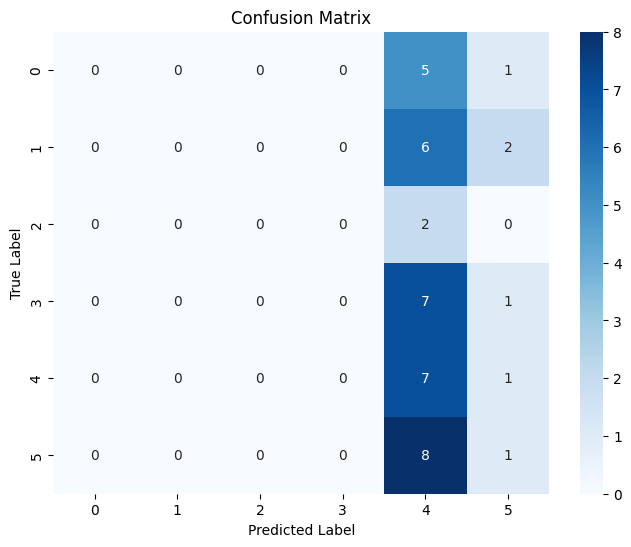

In [25]:
# dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured'
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured'
dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
# dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured'

lr = 0.001
batch_size = 16
patience = 15
num_epochs = 1 #80
num_head = 2
workers = 16

model_path = f"Models/DDAMFNPP_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_P_{patience}_E_{num_epochs}_H_{num_head}_W_{workers}.pth"

# TestDDAMFN(data_directory, model_path, num_head, batch_size)
TestDDAMFN(data_directory, model_path, batch_size)

### Testing on image

In [ ]:
# import torch
# from torchvision import transforms
# from PIL import Image
# import os

# def load_model(checkpoint_path, num_class=7, num_head=2, device='cuda:0'):
#     # Initialize model
#     model = DDAMNet(num_class=num_class, num_head=num_head)
#     model = model.to(device)
    
#     # Load checkpoint
#     if not os.path.exists(checkpoint_path):
#         raise FileNotFoundError(f"Checkpoint file {checkpoint_path} not found")
        
#     checkpoint = torch.load(checkpoint_path, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
    
#     return model

# def process_image(image_path, model, device='cuda:0'):
#     # Define transformations (match validation transforms)
#     transform = transforms.Compose([
#         transforms.Resize((112, 112)),
#         transforms.Grayscale(num_output_channels=3),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225])
#     ])
    
#     # Load and preprocess image
#     img = Image.open(image_path).convert('RGB')
#     input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    
#     # Make prediction
#     with torch.no_grad():
#         outputs, _, _ = model(input_tensor)
#         probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
#         _, predicted_idx = torch.max(outputs, 1)
    
#     return {
#         'class_index': predicted_idx.item(),
#         'class_label': class_names[predicted_idx.item()],
#         'probabilities': probabilities.cpu().numpy()
#     }


# # Configuration (modify as needed)
# checkpoint_path = "TrainedModels/DDAMFN_DatasetFER_ResEmoteNet_Batch32_LR0.0005_Epochs10.pth"
# image_path = "C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\DDAMFN++\Datasets\FER_ResEmoteNet\\test\\test_28713_happy.jpg"
# # class_names = ['Happy', 'Surprised', 'Sad', 'Angry', 'Disgusted', 'Fear'] #JAFFE
# class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] #FER

# # Load model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = load_model(checkpoint_path, num_class=7, device=device)

# # Process image
# result = process_image(image_path, model, device)

# print(f"Predicted class: {result['class_label']}")
# print("Class probabilities:")
# for cls, prob in zip(class_names, result['probabilities']):
#     print(f"{cls}: {prob:.4f}")

Predicted class: Happy
Class probabilities:
Angry: 0.0000
Disgust: 0.0000
Fear: 0.0000
Happy: 1.0000
Sad: 0.0000
Surprise: 0.0000
Neutral: 0.0000
